In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Conv2D, Conv1D, MaxPooling2D, Dropout, Conv2DTranspose
from tensorflow.keras.layers import UpSampling2D, add, Cropping2D, ReLU, BatchNormalization, Lambda, PReLU
from tensorflow.keras.layers import Concatenate, Reshape, MaxPooling1D, Cropping1D, ZeroPadding1D, Flatten
from tensorflow.keras.layers import AveragePooling2D, LSTM, RepeatVector, TimeDistributed, ZeroPadding2D
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.constraints import Constraint
from tensorflow.keras.utils import Sequence, OrderedEnqueuer
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras import activations
from tensorflow.keras.backend import expand_dims, mean, clip

import os
import re
import datetime
from scipy import ndimage, misc
from skimage.transform import resize, rescale
from matplotlib import pyplot
import numpy as np
import matplotlib.pyplot as plt
import random

devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(devices[0], True)
#tf.keras.backend.set_floatx('float16')

In [2]:
height_x = 120
width_x = 120
channels = 3
shape_x = (height_x, width_x, channels)
width_y = 27
shape_y = (height_x, width_y, channels)

data_num = 2
data_dir = f"../../datasets/dataset_0{data_num}/quarter/"
name = "resnet-120x120"

activation = 'relu'
regularizer = regularizers.l1(1e-9)
dropout_ratio = 0.25

batch_size = 32
epochs = 50
learning_rate = 1e-4

workers = 4
max_queue = 6

In [3]:
class DataGenerator(Sequence):

    def __init__(self, list_IDs, batch_size=4,
                    n_channels=1, n_classes=1, shuffle=True):
        self.batch_size = batch_size
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        indexes = []
        for i in range(index*self.batch_size, (index+1)*self.batch_size):
            indexes.append(i)

        list_IDs_temp = [self.list_IDs[k] for k in indexes]
        X, y = self.__data_generation(list_IDs_temp)
        return X, y

    def on_epoch_end(self):
        return 0

    def __data_generation(self, list_IDs_temp):
        Y = []
        X = []
        for i, filename in enumerate(list_IDs_temp):
            if re.search("\.(jpg|jpeg)", filename):
                filepath = os.path.join(data_dir, filename)
                image = pyplot.imread(filepath)
                if len(image.shape) > 2:
                    flip = random.randint(0, 1)
                    if flip:
                        image = np.flip(image, axis=1)
                    crop = random.randint(0, 13)
                    image = image[:,crop:,:]
                    image_x = image[:,:120,:]
                    image_y = image[:,120:147,:]
                    Y.append(image_y)
                    X.append(image_x)
                    #print(f'X: {image_x.shape} | Y: {image_y.shape}\nCrop: {crop} | Image: {image.shape}')
                    
        Y = (1./255) * np.array(Y)
        X = (1./255) * np.array(X)
        return X, Y

### Resnet v1

In [4]:
netname = ''
def block(input, kernels):
    x = Conv2D(kernels, kernel_size=1, strides=(1,1), padding='same')(input)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    x = Conv2D(kernels, kernel_size=3, strides=(1,1), padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    x = Conv2D(4*kernels, kernel_size=1, strides=(1,1), padding='same')(x)
    x = BatchNormalization()(x)
    x_0 = Conv2D(4*kernels, kernel_size=1, strides=(1,1), padding='same')(input)
    x_0 = BatchNormalization()(x_0)

    x = add([x,x_0])
    x = ReLU()(x)
    return x

input_x = Input(shape=shape_x)
x = Lambda(lambda x: x[:,:,-120:,:])(input_x)

x = Conv2D(64, kernel_size=7, strides=(1,1))(x)
x = BatchNormalization()(x)
x = ReLU()(x)
list_x = []
list_x.append(x)
x = MaxPooling2D(pool_size=(3,3), strides=(2,2))(x)

for i in range(4):
    list_x.append(x)
    for j in range(3):
        x = block(x, 64 * (2**i))
    x = MaxPooling2D()(x)
list_x.append(x)
padding = 'valid'

x = Conv2DTranspose(1024, kernel_size=3,strides=(2,2), padding=padding)(x)
x = BatchNormalization()(x)
x = ReLU()(x)
x = Conv2D(1024, kernel_size=3, strides=(1,1), padding='same')(x)
x = BatchNormalization()(x)
x = add([x,list_x[-2]])
x = ReLU()(x)

x = Conv2DTranspose(512, kernel_size=3,strides=(2,2), padding='same')(x)
x = BatchNormalization()(x)
x = ReLU()(x)
x = Conv2D(512, kernel_size=3, strides=(1,1), padding='same')(x)
x = BatchNormalization()(x)
x = add([x,list_x[-3]])
x = ReLU()(x)
#x = ZeroPadding2D(padding=(1,0))(x)

x = Conv2DTranspose(256, kernel_size=3,strides=(2,2), padding='same')(x)
x = BatchNormalization()(x)
x = ReLU()(x)
x = Conv2D(256, kernel_size=3, strides=(1,1), padding='same')(x)
x = BatchNormalization()(x)
x = add([x,list_x[-4]])
x = ReLU()(x)

x = Cropping2D(cropping=((0,0),(0,1)))(x)

x = Conv2DTranspose(128, kernel_size=3,strides=(2,1), padding='same')(x)
x = BatchNormalization()(x)
x = ReLU()(x)
x = Conv2D(128, kernel_size=3, strides=(1,1), padding='same')(x)
x = BatchNormalization()(x)
x_1 = Conv2D(128, kernel_size=3, strides=(1,2), padding='same')(list_x[1])
x_1 = Cropping2D(cropping=((0,0),(0,1)))(x_1)
x = add([x,x_1])
x = ReLU()(x)

x = Conv2DTranspose(64, kernel_size=3,strides=(2,1), padding='same')(x)
x = BatchNormalization()(x)
x = ReLU()(x)
x = ZeroPadding2D(padding=(1,0))(x)
x = Conv2D(64, kernel_size=3, strides=(1,1), padding='same')(x)
x = BatchNormalization()(x)
x_0 = Conv2D(64, kernel_size=3, strides=(1,4), padding='same')(list_x[0])
x_0 = Cropping2D(cropping=((0,0),(0,2)))(x_0)
x = add([x,x_0])
x = ReLU()(x)

x = Conv2DTranspose(32, kernel_size=(3,1),strides=(1,1), padding='valid')(x)
x = BatchNormalization()(x)
x = ReLU()(x)
x = Conv2D(32, kernel_size=3, strides=(1,1), padding='same')(x)
x = BatchNormalization()(x)
x = ReLU()(x)

x = Conv2DTranspose(32, kernel_size=(3,1),strides=(1,1), padding='valid')(x)
x = BatchNormalization()(x)
x = ReLU()(x)
x = Conv2D(32, kernel_size=3, strides=(1,1), padding='same')(x)
x = BatchNormalization()(x)
x = ReLU()(x)

x = Conv2DTranspose(32, kernel_size=(3,1),strides=(1,1), padding='valid')(x)
x = BatchNormalization()(x)
x = ReLU()(x)
x = Conv2D(32, kernel_size=3, strides=(1,1), padding='same')(x)
x = BatchNormalization()(x)
x = ReLU()(x)

#x = ZeroPadding2D(padding=(3,0))(x)
x = Conv2D(3, kernel_size=5, padding='same', activation='tanh')(x)

#x = Conv2DTranspose(128, kernel_size=3,strides=(2,1), padding=padding)(x)
#x_5 = Conv2DTranspose(64, kernel_size=3,strides=(2,1), padding=padding)(x)
##x = UpSampling2D(size=(4,1))(list_x[2])
#x = AveragePooling2D()(x)
#x = Flatten()(x)
#x = Dense(360, activation='relu', activity_regularizer=regularizer)(x)

#x = Reshape((120,3))(x)

autoencoder = Model(input_x, x)
autoencoder.summary()

Model: &quot;model&quot;
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 120, 120, 3) 0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 120, 120, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 114, 114, 64) 9472        lambda[0][0]                     
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 114, 114, 64) 256         conv2d[0][0]                     
____________________________________________________________________________________

### Resnet v2

In [4]:
netname = '-v2'

def block(input, kernels, downSample=False):
    if downSample:
        x = Conv2D(kernels, kernel_size=1, strides=(2,2), padding='same')(input)
        x_0 = Conv2D(4*kernels, kernel_size=1, strides=(2,2), padding='same')(input)
    else:
        x = Conv2D(kernels, kernel_size=1, strides=(1,1), padding='same')(input)
        x_0 = Conv2D(4*kernels, kernel_size=1, strides=(1,1), padding='same')(input)
    x_0 = BatchNormalization()(x_0)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    x = Conv2D(kernels, kernel_size=3, strides=(1,1), padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    x = Conv2D(4*kernels, kernel_size=1, strides=(1,1), padding='same')(x)
    x = BatchNormalization()(x)
    x = add([x,x_0])
    x = ReLU()(x)

    return x

n_blocks_per_size = [3, 4, 6, 3]

input_x = Input(shape=shape_x)
x = Lambda(lambda x: x[:,:,-120:,:])(input_x)

x = Conv2D(64, kernel_size=7, strides=(1,1), padding='same')(x)
x = BatchNormalization()(x)
x = ReLU()(x)
x = MaxPooling2D(pool_size=(3,3), strides=(2,2), padding='same')(x)

list_x = [x]

for i in range(4):
    for j in range(n_blocks_per_size[i]):
        #print(f'i: {i} | j: {j}')
        if j == 0:
            x = block(x, 64 * (2**i), downSample=True)
        else:
            x = block(x, 64 * (2**i))
    list_x.append(x)

x = Conv2DTranspose(1024, kernel_size=3, strides=(2,2), padding='same')(x)
x = BatchNormalization()(x)
x = ReLU()(x)
x = Conv2D(1024, kernel_size=3, strides=(1,1), padding='same')(x)
x = BatchNormalization()(x)
x = add([x, list_x[-2]])
x = ReLU()(x)

x = Conv2DTranspose(512, kernel_size=3, strides=(2,2), padding='same')(x)
x = Cropping2D(((0, 1),(0, 1)))(x)
x = BatchNormalization()(x)
x = ReLU()(x)
x = Conv2D(512, kernel_size=3, strides=(1,1), padding='same')(x)
x = BatchNormalization()(x)
x = add([x, list_x[-3]])
x = ReLU()(x)

x = Conv2DTranspose(256, kernel_size=3, strides=(2,2), padding='same')(x)
x = BatchNormalization()(x)
x = ReLU()(x)
x = Conv2D(256, kernel_size=3, strides=(1,1), padding='same')(x)
x = BatchNormalization()(x)
x = add([x, list_x[-4]])
x = ReLU()(x)

x = Cropping2D(((0,0),(1,2)))(x)

x = Conv2DTranspose(128, kernel_size=3, strides=(2,1), padding='same')(x)
x = BatchNormalization()(x)
x = ReLU()(x)
x = Conv2D(128, kernel_size=3, strides=(1,1), padding='same')(x)
x = BatchNormalization()(x)
x = ReLU()(x)

x = Conv2DTranspose(64, kernel_size=3, strides=(2,1), padding='same')(x)
x = BatchNormalization()(x)
x = ReLU()(x)
x = Conv2D(64, kernel_size=3, strides=(1,1), padding='same')(x)
x = BatchNormalization()(x)
x = ReLU()(x)

x = Conv2D(3, kernel_size=7, strides=(1,1), padding='same', activation='tanh')(x)

autoencoder = Model(input_x, x)
autoencoder.summary()

for x in list_x:
    print(x)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 120, 120, 3) 0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 120, 120, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 120, 120, 64) 9472        lambda[0][0]                     
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 120, 120, 64) 256         conv2d[0][0]                     
______________________________________________________________________________________________

### Resnet v3

In [4]:
netname = '-v3'
def block(input, kernels, downSample=False):

    if downSample:
        x = Conv2D(kernels, kernel_size=1, strides=(2,2), padding='same')(input)
        x_0 = Conv2D(4*kernels, kernel_size=1, strides=(2,2), padding='same')(input)
    else:
        x = Conv2D(kernels, kernel_size=1, strides=(1,1), padding='same')(input)
        x_0 = Conv2D(4*kernels, kernel_size=1, strides=(1,1), padding='same')(input)
    x_0 = BatchNormalization()(x_0)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    x = Conv2D(kernels, kernel_size=3, strides=(1,1), padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    x = Conv2D(4*kernels, kernel_size=1, strides=(1,1), padding='same')(x)
    x = BatchNormalization()(x)
    x = add([x,x_0])
    x = ReLU()(x)
    x = Dropout(0.2)(x)

    return x

n_blocks_per_size = [3, 4, 6, 3]

input_x = Input(shape=shape_x)
x = Lambda(lambda x: x[:,:,-120:,:])(input_x)

x = Conv2D(64, kernel_size=7, strides=(1,1), padding='same')(x)
x = BatchNormalization()(x)
x = ReLU()(x)
x = MaxPooling2D(pool_size=(3,3), strides=(2,2), padding='same')(x)

list_x = [x]

for i in range(4):
    for j in range(n_blocks_per_size[i]):
        #print(f'i: {i} | j: {j}')
        if j == 0 and i > 0:
            x = block(x, 64 * (2**i), downSample=True)
        else:
            x = block(x, 64 * (2**i))
    list_x.append(x)

x = Conv2DTranspose(1024, kernel_size=3, strides=(2,2), padding='same')(x)
x = Cropping2D(((0, 1),(0, 1)))(x)
x = BatchNormalization()(x)
x = ReLU()(x)
x = Conv2D(1024, kernel_size=3, strides=(1,1), padding='same')(x)
x = BatchNormalization()(x)
x = add([x, list_x[-2]])
x = ReLU()(x)

x = Conv2DTranspose(512, kernel_size=3, strides=(2,2), padding='same')(x)
x = BatchNormalization()(x)
x = ReLU()(x)
x = Conv2D(512, kernel_size=3, strides=(1,1), padding='same')(x)
x = BatchNormalization()(x)
x = add([x, list_x[-3]])
x = ReLU()(x)

x = Cropping2D(((0,0),(1,2)))(x)

x_0 = Conv2D(256, kernel_size=3, strides=(1,2), padding='same')(list_x[-4])
x_0 = BatchNormalization()(x_0)
x_0 = ReLU()(x_0)
x_0 = Conv2D(256, kernel_size=3, strides=(1,1), padding='same')(x_0)
x_0 = BatchNormalization()(x_0)
x_0 = ReLU()(x_0)
x_0 = Cropping2D(((0,0),(1,2)))(x_0)

x = Conv2DTranspose(256, kernel_size=3, strides=(2,1), padding='same')(x)
x = BatchNormalization()(x)
x = ReLU()(x)
x = Conv2D(256, kernel_size=3, strides=(1,1), padding='same')(x)
x = BatchNormalization()(x)
x = add([x, x_0])
x = ReLU()(x)

x = Conv2DTranspose(128, kernel_size=3, strides=(2,1), padding='same')(x)
x = BatchNormalization()(x)
x = ReLU()(x)
x = Conv2D(128, kernel_size=3, strides=(1,1), padding='same')(x)
x = BatchNormalization()(x)
x = ReLU()(x)

x = Conv2D(3, kernel_size=7, strides=(1,1), padding='same', activation='tanh')(x)

autoencoder = Model(input_x, x)
autoencoder.summary()

for x in list_x:
    print(x)

Model: &quot;model&quot;
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 120, 120, 3) 0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 120, 120, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 120, 120, 64) 9472        lambda[0][0]                     
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 120, 120, 64) 256         conv2d[0][0]                     
____________________________________________________________________________________

In [5]:
adam = Adam(learning_rate=learning_rate)
autoencoder.compile(optimizer=adam, loss='mean_squared_error', metrics=['mse'])

In [6]:
files = os.listdir(data_dir)
gen_loader = DataGenerator(files, batch_size=batch_size)
autoencoder.fit(gen_loader, epochs=2*(epochs//10), steps_per_epoch=1000,
            use_multiprocessing=True, workers=workers, shuffle=True)

Epoch 1/10


1/1000 [..............................] - ETA: 0s - loss: 0.4459 - mse: 0.4459

2/1000 [..............................] - ETA: 5:18 - loss: 0.3772 - mse: 0.3772

3/1000 [..............................] - ETA: 7:12 - loss: 0.3265 - mse: 0.3265

4/1000 [..............................] - ETA: 8:01 - loss: 0.2910 - mse: 0.2910

5/1000 [..............................] - ETA: 8:33 - loss: 0.2663 - mse: 0.2663

6/1000 [..............................] - ETA: 9:02 - loss: 0.2453 - mse: 0.2453

7/1000 [..............................] - ETA: 9:15 - loss: 0.2319 - mse: 0.2319

8/1000 [..............................] - ETA: 9:23 - loss: 0.2173 - mse: 0.2173

9/1000 [..............................] - ETA: 9:30 - loss: 0.2079 - mse: 0.2079

10/1000 [..............................] - ETA: 9:35 - loss: 0.1990 - mse: 0.1990

11/1000 [..............................] - ETA: 9:41 - loss: 0.1922 - mse: 0.1922

12/1000 [..............................] - ETA: 9:44 - loss: 0.1852 - mse: 0.1852

13/1000 [..............................] - ETA: 9:46 - loss: 0.1795 - mse: 0.1795

14/1000 [..............................] - ETA: 9:49 - loss: 0.1739 - mse: 0.1739

15/1000 [..............................] - ETA: 9:51 - loss: 0.1704 - mse: 0.1704

16/1000 [..............................] - ETA: 9:54 - loss: 0.1653 - mse: 0.1653

17/1000 [..............................] - ETA: 9:58 - loss: 0.1616 - mse: 0.1616

18/1000 [..............................] - ETA: 10:01 - loss: 0.1586 - mse: 0.1586

19/1000 [..............................] - ETA: 10:02 - loss: 0.1551 - mse: 0.1551

20/1000 [..............................] - ETA: 10:02 - loss: 0.1519 - mse: 0.1519

21/1000 [..............................] - ETA: 10:03 - loss: 0.1491 - mse: 0.1491

22/1000 [..............................] - ETA: 10:05 - loss: 0.1469 - mse: 0.1469

23/1000 [..............................] - ETA: 10:05 - loss: 0.1437 - mse: 0.1437

24/1000 [..............................] - ETA: 10:09 - loss: 0.1416 - mse: 0.1416

25/1000 [..............................] - ETA: 10:11 - loss: 0.1397 - mse: 0.1397

26/1000 [..............................] - ETA: 10:12 - loss: 0.1377 - mse: 0.1377

27/1000 [..............................] - ETA: 10:14 - loss: 0.1356 - mse: 0.1356

28/1000 [..............................] - ETA: 10:14 - loss: 0.1340 - mse: 0.1340

29/1000 [..............................] - ETA: 10:14 - loss: 0.1320 - mse: 0.1320

30/1000 [..............................] - ETA: 10:14 - loss: 0.1300 - mse: 0.1300

31/1000 [..............................] - ETA: 10:14 - loss: 0.1283 - mse: 0.1283

### Epoches saved: 250 L2 + 150 L1

In [9]:
#autoencoder.save_weights('saved_models/'+name+'-l1')

In [23]:
autoencoder.load_weights('saved_models/'+name+'-l1')

&lt;tensorflow.python.training.tracking.util.CheckpointLoadStatus at 0x7fb9e84a4fa0&gt;

### v1: Epoches saved: 250 L2
### v2: Epoches saved: 60 L2
### v3: Epoches saved: 10 L2

In [1]:
#autoencoder.save_weights('saved_models/'+name+netname)

NameError: name 'autoencoder' is not defined

In [7]:
autoencoder.load_weights('saved_models/'+name)

## Results

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


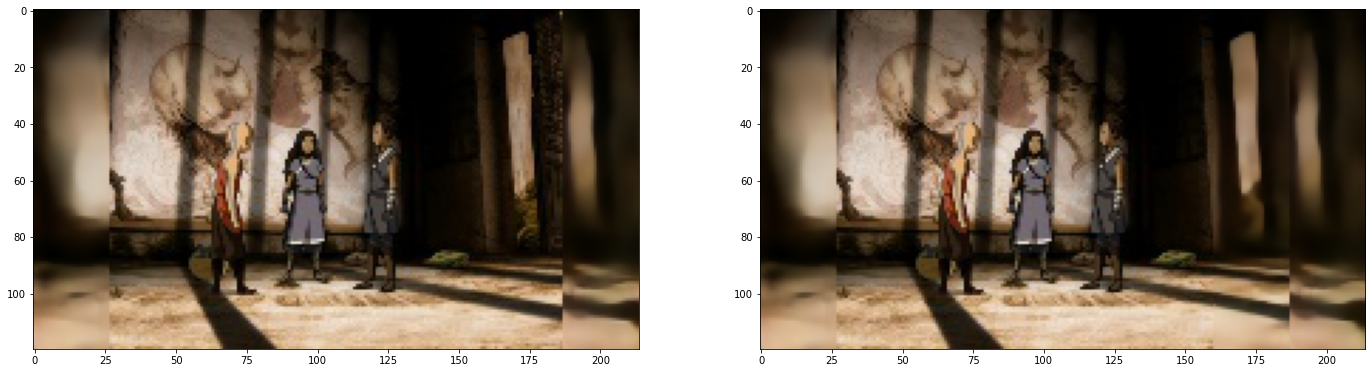

In [126]:
random_names = os.listdir(data_dir)
image_name = random_names[random.randint(0, len(random_names))]
image_true = (1/255.) * np.array(pyplot.imread(os.path.join(data_dir, image_name)), dtype=float)
image = image_true[:,:133,:]

for i in range(2):
    image_x = image[:,-120:,:]
    image_y_pred = autoencoder(np.expand_dims(image_x,axis=0))
    image = np.concatenate((image, image_y_pred[0]), axis=1)

image_x_flip = np.flip(image[:,:120,:], axis=1)
image_y_pred_flip = autoencoder(np.expand_dims(image_x_flip,axis=0))
image_y_pred_flip = np.flip(image_y_pred_flip[0], axis=1)
image = np.concatenate((image_y_pred_flip, image), axis=1)

image_right = autoencoder(np.expand_dims(image_true[:,-120:,:],axis=0))
image_true = np.concatenate((image_true, image_right[0]), axis=1)
image_true = np.concatenate((image_y_pred_flip, image_true), axis=1)

plt.figure(figsize=(128, 128))
ax = plt.subplot(10, 10, 1)
plt.imshow(image_true)
ax = plt.subplot(10, 10, 2)
plt.imshow(image)

if False:
    print(critic(np.expand_dims(image_true[:,-240:-120,:], axis=0)))
    print(critic(np.expand_dims(image_true[:,-120:,:], axis=0)))

## WGAN

In [5]:
def wasserstein_loss(y_true, y_pred):
	return mean(y_true * y_pred)

class ClipConstraint(Constraint):
	# set clip value when initialized
	def __init__(self, clip_value):
		self.clip_value = clip_value

	def __call__(self, weights):
		return clip(weights, -self.clip_value, self.clip_value)

	def get_config(self):
		return {'clip_value': self.clip_value}

### Critic Model

In [6]:
filters = 64
init = RandomNormal(stddev=0.02)
const = ClipConstraint(0.01)

def conv2d_block(input, filters, strides=1, bn=True, dropout=0):
    d = Conv2D(filters, kernel_size=3, strides=strides, padding='same',
                kernel_initializer=init, kernel_constraint=const)(input)
    if bn:
        d = BatchNormalization(momentum=0.8)(d)
    if dropout > 0:
        d = Dropout(dropout)(d)
    d = LeakyReLU(alpha=0.2)(d)
    return d

critic_input = Input(shape=(120,27,3))
x = conv2d_block(critic_input, filters, bn=False)
x = conv2d_block(x, filters, strides=2, bn=False, dropout=0.3)
x = conv2d_block(x, filters*2, bn=False)
x = conv2d_block(x, filters*2, strides=2, bn=False, dropout=0.3)
x = conv2d_block(x, filters*4, bn=False)
x = conv2d_block(x, filters*4, strides=2, bn=False, dropout=0.3)
x = conv2d_block(x, filters*8, bn=False)
x = conv2d_block(x, filters*8, strides=2, bn=False, dropout=0.3)
x = Flatten()(x)
x = Dropout(0.2)(x)
x = Dense(1)(x)


critic = Model(critic_input, x)
critic.summary()


Model: &quot;model_1&quot;
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 120, 27, 3)]      0         
_________________________________________________________________
conv2d_60 (Conv2D)           (None, 120, 27, 64)       1792      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 120, 27, 64)       0         
_________________________________________________________________
conv2d_61 (Conv2D)           (None, 60, 14, 64)        36928     
_________________________________________________________________
dropout (Dropout)            (None, 60, 14, 64)        0         
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 60, 14, 64)        0         
_________________________________________________________________
conv2d_62 (Conv2D)           (None, 60, 14, 128) 

In [7]:
opt = RMSprop(lr=0.00005)
critic.compile(loss=wasserstein_loss, optimizer=opt)

### Gan Model

In [8]:
critic.trainable = False
gan = Sequential()
gan.add(autoencoder)
gan.add(critic)

opt = RMSprop(lr=0.00005)
gan.compile(loss=wasserstein_loss, optimizer=opt)
gan.summary()

Model: &quot;sequential&quot;
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model (Model)                (None, 120, 27, 3)        69005283  
_________________________________________________________________
model_1 (Model)              (None, 1)                 4693569   
Total params: 73,698,852
Trainable params: 68,939,235
Non-trainable params: 4,759,617
_________________________________________________________________


In [57]:
print_frequency = 50
start_epoch = datetime.datetime.now()

loader = DataGenerator(os.listdir(data_dir), batch_size=batch_size)
half_loader = DataGenerator(os.listdir(data_dir), batch_size=batch_size//2)
enqueuer = OrderedEnqueuer(loader, use_multiprocessing=True, shuffle=True)
enqueuer.start(workers=workers, max_queue_size=max_queue)
output_generator = enqueuer.get()
enqueuer_half = OrderedEnqueuer(half_loader, use_multiprocessing=True, shuffle=True)
enqueuer_half.start(workers=workers, max_queue_size=max_queue)
output_half_generator = enqueuer_half.get()

gan_output_size = (batch_size, gan.output_shape[1])
gan_real = -np.ones(gan_output_size)
critic_output_size = (batch_size//2, critic.output_shape[1])
critic_real = -np.ones(critic_output_size)
critic_fake = np.ones(critic_output_size)
n_critic = 5
epoch_scale = 100

if c1_hist is None or c2_hist is None or g_hist is None:
    c1_hist, c2_hist, g_hist = list(), list(), list()

for epoch in range(1, (epoch_scale*epochs)+1):
    if (epoch-1) % (print_frequency) == 1:
        start_epoch = datetime.datetime.now()

    c1_tmp, c2_tmp = list(), list()
    for _ in range(n_critic):
        X, Y = next(output_half_generator)
        c1_loss = critic.train_on_batch(Y, critic_real)
        c1_tmp.append(c1_loss)
        Y_fake = autoencoder(X)
        c2_loss = critic.train_on_batch(Y_fake, critic_fake)
        c2_tmp.append(c2_loss)
    c1_hist.append(np.mean(c1_tmp))
    c2_hist.append(np.mean(c2_tmp))

    X, _ = next(output_generator)
    g_loss = gan.train_on_batch(X, gan_real)
    g_hist.append(g_loss)

    if epoch % print_frequency == 1:
        time = (datetime.datetime.now() - start_epoch).seconds
        c1_avg = np.mean(c1_hist[-print_frequency:])
        c2_avg = np.mean(c2_hist[-print_frequency:])
        g_avg = np.mean(g_hist[-print_frequency:])
        print(f'\nEpoch {epoch}/{epoch_scale*epochs} | Time: {time}\nCritic:'+
            f'\n\tReal Loss:{c1_avg:.4E} \n\tFake Loss:{c2_avg:.4E}' +
            f'\nGenerator:\n\t     Loss:{g_avg:.4E}')


Epoch 1/5000 | Time: 2
Critic:
	Real Loss:1.1468E-04 
	Fake Loss:2.3289E-04
Generator:
	     Loss:1.5520E-04



Epoch 51/5000 | Time: 48
Critic:
	Real Loss:1.4735E-04 
	Fake Loss:2.7026E-04
Generator:
	     Loss:2.0190E-04



Epoch 101/5000 | Time: 48
Critic:
	Real Loss:1.2581E-04 
	Fake Loss:2.7705E-04
Generator:
	     Loss:8.7863E-05



Epoch 151/5000 | Time: 48
Critic:
	Real Loss:7.4618E-05 
	Fake Loss:4.4036E-04
Generator:
	     Loss:2.2925E-04



Epoch 201/5000 | Time: 48
Critic:
	Real Loss:5.3103E-05 
	Fake Loss:3.2617E-04
Generator:
	     Loss:7.2329E-06



Epoch 251/5000 | Time: 48
Critic:
	Real Loss:9.1902E-05 
	Fake Loss:3.0041E-04
Generator:
	     Loss:1.9023E-04



Epoch 301/5000 | Time: 48
Critic:
	Real Loss:1.4777E-04 
	Fake Loss:1.8287E-04
Generator:
	     Loss:3.8294E-04



Epoch 351/5000 | Time: 48
Critic:
	Real Loss:1.4626E-04 
	Fake Loss:2.3252E-04
Generator:
	     Loss:3.7498E-04



Epoch 401/5000 | Time: 48
Critic:
	Real Loss:1.6834E-04 
	Fake Loss:3.2607E-04
Generator:
	     Loss:4.0493E-04



Epoch 451/5000 | Time: 50
Critic:
	Real Loss:1.8643E-04 
	Fake Loss:2.8401E-04
Generator:
	     Loss:1.6049E-04



Epoch 501/5000 | Time: 50
Critic:
	Real Loss:1.1961E-04 
	Fake Loss:2.9006E-04
Generator:
	     Loss:8.3131E-05



Epoch 551/5000 | Time: 51
Critic:
	Real Loss:1.4429E-04 
	Fake Loss:3.2732E-04
Generator:
	     Loss:9.0299E-05



Epoch 601/5000 | Time: 50
Critic:
	Real Loss:1.7848E-04 
	Fake Loss:2.5784E-04
Generator:
	     Loss:1.8102E-04



Epoch 651/5000 | Time: 49
Critic:
	Real Loss:1.6283E-04 
	Fake Loss:2.3681E-04
Generator:
	     Loss:1.2042E-04



Epoch 701/5000 | Time: 49
Critic:
	Real Loss:1.6981E-04 
	Fake Loss:2.8831E-04
Generator:
	     Loss:2.2172E-04



Epoch 751/5000 | Time: 50
Critic:
	Real Loss:1.0503E-04 
	Fake Loss:3.2824E-04
Generator:
	     Loss:7.8727E-05



Epoch 801/5000 | Time: 50
Critic:
	Real Loss:1.6036E-04 
	Fake Loss:3.1100E-04
Generator:
	     Loss:4.9376E-05



Epoch 851/5000 | Time: 49
Critic:
	Real Loss:6.6416E-05 
	Fake Loss:3.6476E-04
Generator:
	     Loss:5.5652E-05



Epoch 901/5000 | Time: 51
Critic:
	Real Loss:1.1897E-04 
	Fake Loss:2.9754E-04
Generator:
	     Loss:-3.4251E-05



Epoch 951/5000 | Time: 51
Critic:
	Real Loss:8.4099E-05 
	Fake Loss:3.5390E-04
Generator:
	     Loss:2.3021E-04



Epoch 1001/5000 | Time: 50
Critic:
	Real Loss:1.3565E-04 
	Fake Loss:2.6653E-04
Generator:
	     Loss:5.1336E-05



Epoch 1051/5000 | Time: 50
Critic:
	Real Loss:1.6141E-04 
	Fake Loss:2.7553E-04
Generator:
	     Loss:1.0928E-04



Epoch 1101/5000 | Time: 51
Critic:
	Real Loss:1.8847E-04 
	Fake Loss:2.7011E-04
Generator:
	     Loss:1.8290E-04



Epoch 1151/5000 | Time: 50
Critic:
	Real Loss:1.5291E-04 
	Fake Loss:2.4156E-04
Generator:
	     Loss:2.5892E-04



Epoch 1201/5000 | Time: 50
Critic:
	Real Loss:1.7900E-04 
	Fake Loss:2.9636E-04
Generator:
	     Loss:1.5584E-04



Epoch 1251/5000 | Time: 50
Critic:
	Real Loss:1.3085E-04 
	Fake Loss:3.0260E-04
Generator:
	     Loss:1.7540E-04



Epoch 1301/5000 | Time: 50
Critic:
	Real Loss:8.2556E-05 
	Fake Loss:3.0605E-04
Generator:
	     Loss:1.7997E-04



Epoch 1351/5000 | Time: 51
Critic:
	Real Loss:1.2960E-04 
	Fake Loss:3.6682E-04
Generator:
	     Loss:1.5887E-04



Epoch 1401/5000 | Time: 50
Critic:
	Real Loss:1.4145E-04 
	Fake Loss:2.4546E-04
Generator:
	     Loss:1.9200E-05



Epoch 1451/5000 | Time: 50
Critic:
	Real Loss:9.2310E-05 
	Fake Loss:3.2821E-04
Generator:
	     Loss:2.3678E-04



Epoch 1501/5000 | Time: 50
Critic:
	Real Loss:1.3936E-04 
	Fake Loss:3.0442E-04
Generator:
	     Loss:2.3954E-04



Epoch 1551/5000 | Time: 50
Critic:
	Real Loss:1.6383E-04 
	Fake Loss:3.1456E-04
Generator:
	     Loss:4.0740E-04



Epoch 1601/5000 | Time: 48
Critic:
	Real Loss:9.4424E-05 
	Fake Loss:3.5390E-04
Generator:
	     Loss:1.4743E-04



Epoch 1651/5000 | Time: 48
Critic:
	Real Loss:1.2454E-04 
	Fake Loss:3.4215E-04
Generator:
	     Loss:3.0994E-05



Epoch 1701/5000 | Time: 48
Critic:
	Real Loss:8.2373E-05 
	Fake Loss:4.0305E-04
Generator:
	     Loss:2.1572E-04



Epoch 1751/5000 | Time: 48
Critic:
	Real Loss:7.3839E-05 
	Fake Loss:3.9492E-04
Generator:
	     Loss:3.5228E-04



Epoch 1801/5000 | Time: 48
Critic:
	Real Loss:6.7548E-05 
	Fake Loss:4.2191E-04
Generator:
	     Loss:-7.5853E-05



Epoch 1851/5000 | Time: 48
Critic:
	Real Loss:5.4015E-05 
	Fake Loss:4.8236E-04
Generator:
	     Loss:6.0131E-05



Epoch 1901/5000 | Time: 48
Critic:
	Real Loss:1.2167E-04 
	Fake Loss:3.1861E-04
Generator:
	     Loss:8.6349E-05



Epoch 1951/5000 | Time: 49
Critic:
	Real Loss:1.1290E-04 
	Fake Loss:2.9948E-04
Generator:
	     Loss:4.2411E-04



Epoch 2001/5000 | Time: 49
Critic:
	Real Loss:1.8143E-04 
	Fake Loss:3.3381E-04
Generator:
	     Loss:1.2458E-04



Epoch 2051/5000 | Time: 50
Critic:
	Real Loss:1.1611E-04 
	Fake Loss:2.3546E-04
Generator:
	     Loss:1.1478E-04



Epoch 2101/5000 | Time: 50
Critic:
	Real Loss:1.5184E-04 
	Fake Loss:3.2058E-04
Generator:
	     Loss:1.7083E-04



Epoch 2151/5000 | Time: 50
Critic:
	Real Loss:1.4166E-04 
	Fake Loss:2.5524E-04
Generator:
	     Loss:9.0340E-05



Epoch 2201/5000 | Time: 49
Critic:
	Real Loss:5.9457E-05 
	Fake Loss:3.0351E-04
Generator:
	     Loss:1.8160E-04



Epoch 2251/5000 | Time: 48
Critic:
	Real Loss:2.6121E-04 
	Fake Loss:3.0495E-04
Generator:
	     Loss:-7.8518E-05



Epoch 2301/5000 | Time: 48
Critic:
	Real Loss:2.5829E-04 
	Fake Loss:2.4726E-04
Generator:
	     Loss:2.8734E-04



Epoch 2351/5000 | Time: 48
Critic:
	Real Loss:2.0189E-04 
	Fake Loss:3.3359E-04
Generator:
	     Loss:1.1803E-06



Epoch 2401/5000 | Time: 49
Critic:
	Real Loss:1.5921E-04 
	Fake Loss:2.2437E-04
Generator:
	     Loss:2.9704E-04



Epoch 2451/5000 | Time: 49
Critic:
	Real Loss:1.9651E-04 
	Fake Loss:2.9018E-04
Generator:
	     Loss:2.1567E-04



Epoch 2501/5000 | Time: 49
Critic:
	Real Loss:1.6679E-04 
	Fake Loss:3.3819E-04
Generator:
	     Loss:-7.8027E-06



Epoch 2551/5000 | Time: 49
Critic:
	Real Loss:1.1889E-04 
	Fake Loss:3.8662E-04
Generator:
	     Loss:1.0031E-04



Epoch 2601/5000 | Time: 49
Critic:
	Real Loss:1.1380E-04 
	Fake Loss:3.4271E-04
Generator:
	     Loss:-4.4137E-05



Epoch 2651/5000 | Time: 50
Critic:
	Real Loss:2.0670E-04 
	Fake Loss:2.3294E-04
Generator:
	     Loss:1.5739E-04



Epoch 2701/5000 | Time: 49
Critic:
	Real Loss:2.0458E-04 
	Fake Loss:2.9049E-04
Generator:
	     Loss:1.0518E-04



Epoch 2751/5000 | Time: 49
Critic:
	Real Loss:1.3011E-04 
	Fake Loss:2.7690E-04
Generator:
	     Loss:2.2056E-04



Epoch 2801/5000 | Time: 49
Critic:
	Real Loss:7.5215E-05 
	Fake Loss:2.9917E-04
Generator:
	     Loss:9.3703E-06



Epoch 2851/5000 | Time: 50
Critic:
	Real Loss:9.5756E-05 
	Fake Loss:1.4744E-04
Generator:
	     Loss:1.9925E-04



Epoch 2901/5000 | Time: 50
Critic:
	Real Loss:2.1650E-04 
	Fake Loss:2.7429E-04
Generator:
	     Loss:1.3049E-04



Epoch 2951/5000 | Time: 50
Critic:
	Real Loss:1.4237E-04 
	Fake Loss:4.2156E-04
Generator:
	     Loss:-2.1425E-05



Epoch 3001/5000 | Time: 50
Critic:
	Real Loss:1.8582E-04 
	Fake Loss:2.9694E-04
Generator:
	     Loss:1.9145E-04



Epoch 3051/5000 | Time: 50
Critic:
	Real Loss:1.6369E-04 
	Fake Loss:2.9929E-04
Generator:
	     Loss:1.8507E-04



Epoch 3101/5000 | Time: 50
Critic:
	Real Loss:2.5004E-04 
	Fake Loss:3.1945E-04
Generator:
	     Loss:1.6094E-04



Epoch 3151/5000 | Time: 50
Critic:
	Real Loss:1.1824E-04 
	Fake Loss:2.1159E-04
Generator:
	     Loss:3.1301E-04



Epoch 3201/5000 | Time: 50
Critic:
	Real Loss:1.3386E-04 
	Fake Loss:3.9057E-04
Generator:
	     Loss:-1.0582E-05



Epoch 3251/5000 | Time: 50
Critic:
	Real Loss:2.0750E-04 
	Fake Loss:3.4842E-04
Generator:
	     Loss:2.4342E-04



Epoch 3301/5000 | Time: 51
Critic:
	Real Loss:2.6557E-05 
	Fake Loss:3.5240E-04
Generator:
	     Loss:1.3489E-04



Epoch 3351/5000 | Time: 50
Critic:
	Real Loss:9.4298E-05 
	Fake Loss:4.3957E-04
Generator:
	     Loss:1.1928E-04



Epoch 3401/5000 | Time: 50
Critic:
	Real Loss:4.2756E-05 
	Fake Loss:2.6332E-04
Generator:
	     Loss:1.9339E-04



Epoch 3451/5000 | Time: 50
Critic:
	Real Loss:1.3750E-04 
	Fake Loss:3.7260E-04
Generator:
	     Loss:1.3650E-04



Epoch 3501/5000 | Time: 50
Critic:
	Real Loss:2.0340E-04 
	Fake Loss:3.2089E-04
Generator:
	     Loss:8.7906E-05



Epoch 3551/5000 | Time: 51
Critic:
	Real Loss:2.6333E-04 
	Fake Loss:2.6199E-04
Generator:
	     Loss:8.1848E-06



Epoch 3601/5000 | Time: 51
Critic:
	Real Loss:1.3305E-04 
	Fake Loss:4.0135E-04
Generator:
	     Loss:-7.8719E-05



Epoch 3651/5000 | Time: 50
Critic:
	Real Loss:2.2037E-04 
	Fake Loss:3.2016E-04
Generator:
	     Loss:1.9814E-04



Epoch 3701/5000 | Time: 50
Critic:
	Real Loss:1.0796E-04 
	Fake Loss:3.9355E-04
Generator:
	     Loss:8.4922E-06



Epoch 3751/5000 | Time: 50
Critic:
	Real Loss:1.5679E-04 
	Fake Loss:3.1787E-04
Generator:
	     Loss:1.3321E-04



Epoch 3801/5000 | Time: 50
Critic:
	Real Loss:1.0276E-04 
	Fake Loss:2.7022E-04
Generator:
	     Loss:1.5200E-04



Epoch 3851/5000 | Time: 49
Critic:
	Real Loss:1.5005E-04 
	Fake Loss:3.4677E-04
Generator:
	     Loss:1.7497E-04



Epoch 3901/5000 | Time: 49
Critic:
	Real Loss:2.0962E-04 
	Fake Loss:3.2395E-04
Generator:
	     Loss:2.4136E-04



Epoch 3951/5000 | Time: 49
Critic:
	Real Loss:1.1396E-04 
	Fake Loss:2.8373E-04
Generator:
	     Loss:-5.1396E-05



Epoch 4001/5000 | Time: 49
Critic:
	Real Loss:1.3405E-04 
	Fake Loss:3.6823E-04
Generator:
	     Loss:-1.6754E-05



Epoch 4051/5000 | Time: 49
Critic:
	Real Loss:1.2579E-04 
	Fake Loss:3.0597E-04
Generator:
	     Loss:1.6313E-04



Epoch 4101/5000 | Time: 49
Critic:
	Real Loss:1.4543E-04 
	Fake Loss:3.8624E-04
Generator:
	     Loss:1.1061E-04



Epoch 4151/5000 | Time: 48
Critic:
	Real Loss:1.4892E-04 
	Fake Loss:3.0177E-04
Generator:
	     Loss:6.9414E-05



Epoch 4201/5000 | Time: 50
Critic:
	Real Loss:1.3304E-04 
	Fake Loss:2.9890E-04
Generator:
	     Loss:1.8228E-05



Epoch 4251/5000 | Time: 49
Critic:
	Real Loss:6.4781E-05 
	Fake Loss:4.3515E-04
Generator:
	     Loss:8.5713E-05



Epoch 4301/5000 | Time: 50
Critic:
	Real Loss:1.1609E-04 
	Fake Loss:3.2815E-04
Generator:
	     Loss:3.6928E-05



Epoch 4351/5000 | Time: 50
Critic:
	Real Loss:1.5296E-04 
	Fake Loss:2.8517E-04
Generator:
	     Loss:5.4240E-06



Epoch 4401/5000 | Time: 50
Critic:
	Real Loss:6.4947E-05 
	Fake Loss:2.6499E-04
Generator:
	     Loss:-9.3421E-05



Epoch 4451/5000 | Time: 49
Critic:
	Real Loss:1.5378E-04 
	Fake Loss:2.8188E-04
Generator:
	     Loss:1.2834E-04



Epoch 4501/5000 | Time: 51
Critic:
	Real Loss:1.3920E-04 
	Fake Loss:3.6719E-04
Generator:
	     Loss:2.2619E-04



Epoch 4551/5000 | Time: 50
Critic:
	Real Loss:1.2512E-04 
	Fake Loss:4.0519E-04
Generator:
	     Loss:3.5356E-05



Epoch 4601/5000 | Time: 50
Critic:
	Real Loss:1.3336E-04 
	Fake Loss:2.7006E-04
Generator:
	     Loss:3.1569E-04



Epoch 4651/5000 | Time: 49
Critic:
	Real Loss:2.1312E-04 
	Fake Loss:3.3584E-04
Generator:
	     Loss:2.7074E-04



Epoch 4701/5000 | Time: 49
Critic:
	Real Loss:1.5404E-04 
	Fake Loss:2.4077E-04
Generator:
	     Loss:1.5450E-04



Epoch 4751/5000 | Time: 48
Critic:
	Real Loss:1.1383E-04 
	Fake Loss:2.8954E-04
Generator:
	     Loss:1.5181E-04



Epoch 4801/5000 | Time: 49
Critic:
	Real Loss:1.4952E-04 
	Fake Loss:3.4664E-04
Generator:
	     Loss:9.3191E-05



Epoch 4851/5000 | Time: 48
Critic:
	Real Loss:1.6846E-04 
	Fake Loss:3.3470E-04
Generator:
	     Loss:4.2634E-05



Epoch 4901/5000 | Time: 48
Critic:
	Real Loss:1.1558E-04 
	Fake Loss:3.0268E-04
Generator:
	     Loss:3.1229E-04



Epoch 4951/5000 | Time: 49
Critic:
	Real Loss:1.1631E-04 
	Fake Loss:4.1505E-04
Generator:
	     Loss:-8.2577E-05


In [ ]:
autoencoder.save_weights('saved_models/'+name+netname+'-gan')
critic.save_weights('saved_models/'+name+netname+'-critic')
#autoencoder.load_weights('saved_models/'+name+netname+'-gan')
#critic.load_weights('saved_models/'+name+netname+'-critic')

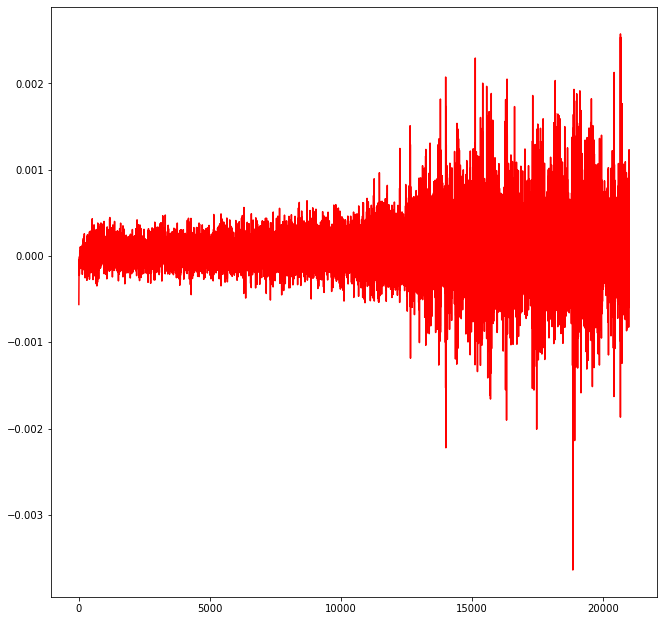

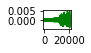

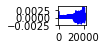

In [60]:
autoencoder.save_weights('saved_models/'+name+netname+'-gan')
critic.save_weights('saved_models/'+name+netname+'-critic')

time = range(len(g_hist))
plt.figure(figsize=(128, 128))
ax = plt.subplot(10, 10, 1)
plt.plot(time, c1_hist, 'r')
plt.show()
ax = plt.subplot(10, 10, 2)
plt.plot(time, g_hist, 'g')
plt.show()
ax = plt.subplot(10, 10, 3)
plt.plot(time, c2_hist, 'b')
plt.show()

## GAN

In [7]:
def conv2d_block(input, filters, strides=1, bn=True):
    d = Conv2D(filters, kernel_size=3, strides=strides, padding='same')(input)
    if bn:
        d = BatchNormalization(momentum=0.8)(d)
    d = LeakyReLU(alpha=0.2)(d)
    return d

filters = 64

discriminator_input = Input(shape=(120,27,3))
x = conv2d_block(discriminator_input, filters, bn=False)
x = conv2d_block(x, filters, strides=2)
x = conv2d_block(x, filters*2)
x = conv2d_block(x, filters*2, strides=2)
x = conv2d_block(x, filters*4)
x = conv2d_block(x, filters*4, strides=2)
x = Dense(filters*8)(x)
x = LeakyReLU(alpha=0.2)(x)
x = Dense(1, activation='sigmoid')(x)

discriminator = Model(inputs=discriminator_input, outputs=x)
discriminator.summary()

Model: &quot;model_1&quot;
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 120, 27, 3)]      0         
_________________________________________________________________
conv2d_60 (Conv2D)           (None, 120, 27, 64)       1792      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 120, 27, 64)       0         
_________________________________________________________________
conv2d_61 (Conv2D)           (None, 60, 14, 64)        36928     
_________________________________________________________________
batch_normalization_65 (Batc (None, 60, 14, 64)        256       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 60, 14, 64)        0         
_________________________________________________________________
conv2d_62 (Conv2D)           (None, 60, 14, 128) 

In [8]:
discriminator.compile(optimizer=Adam(learning_rate=learning_rate*0.5, beta_1=0.5),
                        loss='binary_crossentropy', metrics=['accuracy'])

In [9]:
discriminator.trainable = False
gan = Sequential()
gan.add(autoencoder)
gan.add(discriminator)

gan.compile(optimizer=Adam(learning_rate=learning_rate*0.5, beta_1=0.5), loss='binary_crossentropy')
gan.summary()

Model: &quot;sequential&quot;
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model (Model)                (None, 120, 27, 3)        69005283  
_________________________________________________________________
model_1 (Model)              (None, 15, 4, 1)          1280833   
Total params: 70,286,116
Trainable params: 68,939,235
Non-trainable params: 1,346,881
_________________________________________________________________


In [10]:
print_frequency = 25
start_epoch = datetime.datetime.now()

loader = DataGenerator(os.listdir(data_dir), batch_size=batch_size)
half_loader = DataGenerator(os.listdir(data_dir), batch_size=batch_size//2)
enqueuer = OrderedEnqueuer(loader, use_multiprocessing=True, shuffle=True)
enqueuer.start(workers=workers, max_queue_size=max_queue)
output_generator = enqueuer.get()
enqueuer_half = OrderedEnqueuer(half_loader, use_multiprocessing=True, shuffle=True)
enqueuer_half.start(workers=workers, max_queue_size=max_queue)
output_half_generator = enqueuer_half.get()

disciminator_output_shape = list(discriminator.output_shape)
disciminator_output_shape[0] = batch_size//2
disciminator_output_shape = tuple(disciminator_output_shape)
real_half = np.ones(disciminator_output_shape)
fake_half = np.zeros(disciminator_output_shape)

gan_output_shape = list(discriminator.output_shape)
gan_output_shape[0] = batch_size
gan_output_shape = tuple(gan_output_shape)
real = np.ones(gan_output_shape)

epoch_scale = 60

d_real_hist, d_fake_hist, g_hist = list(), list(), list()

for epoch in range(1, (epoch_scale*epochs)+1):
    if (epoch-1) % (print_frequency) == 1:
        start_epoch = datetime.datetime.now()

    X_half, real_Y_half = next(output_half_generator)
    fake_y_half = autoencoder.predict(X_half)

    real_loss = discriminator.train_on_batch(real_Y_half, real_half)
    fake_loss = discriminator.train_on_batch(fake_y_half, fake_half)
    discriminator_loss = 0.5 * np.add(real_loss, fake_loss)

    X, real_Y = next(output_generator)
    generator_loss = gan.train_on_batch(X, real)

    d_real_hist.append(real_loss)
    d_fake_hist.append(fake_loss)
    g_hist.append(generator_loss)

    if epoch % print_frequency == 1 and epoch > print_frequency:
        time = (datetime.datetime.now() - start_epoch).seconds
        d_fake_loss_avg = 0.
        d_fake_acc_avg = 0.
        d_real_loss_avg = 0.
        d_real_acc_avg = 0.
        for i in range(print_frequency):
            d_fake_loss_avg += d_fake_hist[-i][0]
            d_fake_acc_avg += d_fake_hist[-i][1]
            d_real_loss_avg += d_real_hist[-i][0]
            d_real_acc_avg += d_real_hist[-i][1]
        d_fake_loss_avg = d_fake_loss_avg/print_frequency
        d_fake_acc_avg = d_fake_acc_avg/print_frequency
        d_real_loss_avg = d_real_loss_avg/print_frequency
        d_real_acc_avg = d_real_acc_avg/print_frequency
        #print(d_avg)
        g_avg = np.mean(g_hist[-print_frequency:])
        #print(discriminator.metrics_names)
        print(f'\nEpoch {epoch}/{epoch_scale*epochs} | Time: {time}\nDiscriminator:'+
            f'\n\tReal Loss:{d_real_loss_avg:.4E}\tAccuracy: {d_real_acc_avg:.4f}' +
            f'\n\tFake Loss:{d_fake_loss_avg:.4E}\tAccuracy: {d_fake_acc_avg:.4f}' +
            f'\nGenerator:\n\t     Loss:{g_avg:.4E}')


Epoch 26/3000 | Time: 12
Discriminator:
	Real Loss:6.9294E-01	Accuracy: 0.5346
	Fake Loss:7.0616E-01	Accuracy: 0.5323
Generator:
	     Loss:6.9309E-01



Epoch 51/3000 | Time: 12
Discriminator:
	Real Loss:6.7035E-01	Accuracy: 0.6207
	Fake Loss:6.4691E-01	Accuracy: 0.7004
Generator:
	     Loss:7.2792E-01



Epoch 76/3000 | Time: 12
Discriminator:
	Real Loss:6.2735E-01	Accuracy: 0.7105
	Fake Loss:6.3919E-01	Accuracy: 0.6842
Generator:
	     Loss:6.7648E-01



Epoch 101/3000 | Time: 12
Discriminator:
	Real Loss:5.4593E-01	Accuracy: 0.8143
	Fake Loss:5.7578E-01	Accuracy: 0.7632
Generator:
	     Loss:5.6417E-01



Epoch 126/3000 | Time: 12
Discriminator:
	Real Loss:3.2552E-01	Accuracy: 0.9600
	Fake Loss:3.5396E-01	Accuracy: 0.9488
Generator:
	     Loss:3.8735E-01



Epoch 151/3000 | Time: 12
Discriminator:
	Real Loss:1.7962E-01	Accuracy: 0.9828
	Fake Loss:2.2736E-01	Accuracy: 0.9639
Generator:
	     Loss:3.3752E-01



Epoch 176/3000 | Time: 12
Discriminator:
	Real Loss:1.2900E-01	Accuracy: 0.9831
	Fake Loss:1.4256E-01	Accuracy: 0.9690
Generator:
	     Loss:3.1707E-01



Epoch 201/3000 | Time: 12
Discriminator:
	Real Loss:1.1627E-01	Accuracy: 0.9828
	Fake Loss:1.3519E-01	Accuracy: 0.9588
Generator:
	     Loss:3.2389E-01



Epoch 226/3000 | Time: 12
Discriminator:
	Real Loss:9.0407E-02	Accuracy: 0.9831
	Fake Loss:1.0394E-01	Accuracy: 0.9691
Generator:
	     Loss:1.8632E-01



Epoch 251/3000 | Time: 11
Discriminator:
	Real Loss:7.8437E-02	Accuracy: 0.9831
	Fake Loss:8.8220E-02	Accuracy: 0.9691
Generator:
	     Loss:1.4892E-01



Epoch 276/3000 | Time: 11
Discriminator:
	Real Loss:6.9937E-02	Accuracy: 0.9831
	Fake Loss:8.3651E-02	Accuracy: 0.9691
Generator:
	     Loss:1.2398E-01



Epoch 301/3000 | Time: 11
Discriminator:
	Real Loss:6.6582E-02	Accuracy: 0.9831
	Fake Loss:9.0264E-02	Accuracy: 0.9679
Generator:
	     Loss:8.9351E-02



Epoch 326/3000 | Time: 11
Discriminator:
	Real Loss:6.4366E-02	Accuracy: 0.9831
	Fake Loss:7.4359E-02	Accuracy: 0.9690
Generator:
	     Loss:8.1014E-02



Epoch 351/3000 | Time: 11
Discriminator:
	Real Loss:5.6987E-02	Accuracy: 0.9831
	Fake Loss:6.5333E-02	Accuracy: 0.9691
Generator:
	     Loss:6.4388E-02



Epoch 376/3000 | Time: 11
Discriminator:
	Real Loss:5.3377E-02	Accuracy: 0.9831
	Fake Loss:6.2883E-02	Accuracy: 0.9691
Generator:
	     Loss:5.0463E-02



Epoch 401/3000 | Time: 11
Discriminator:
	Real Loss:5.0826E-02	Accuracy: 0.9831
	Fake Loss:6.1463E-02	Accuracy: 0.9691
Generator:
	     Loss:4.8022E-02



Epoch 426/3000 | Time: 11
Discriminator:
	Real Loss:4.8373E-02	Accuracy: 0.9831
	Fake Loss:5.8834E-02	Accuracy: 0.9691
Generator:
	     Loss:4.1379E-02



Epoch 451/3000 | Time: 11
Discriminator:
	Real Loss:4.6070E-02	Accuracy: 0.9831
	Fake Loss:5.6999E-02	Accuracy: 0.9691
Generator:
	     Loss:4.6071E-02



Epoch 476/3000 | Time: 11
Discriminator:
	Real Loss:4.4677E-02	Accuracy: 0.9831
	Fake Loss:5.4136E-02	Accuracy: 0.9691
Generator:
	     Loss:5.2367E-02



Epoch 501/3000 | Time: 11
Discriminator:
	Real Loss:4.2735E-02	Accuracy: 0.9831
	Fake Loss:5.3892E-02	Accuracy: 0.9691
Generator:
	     Loss:4.2212E-02



Epoch 526/3000 | Time: 12
Discriminator:
	Real Loss:4.1506E-02	Accuracy: 0.9831
	Fake Loss:4.9989E-02	Accuracy: 0.9691
Generator:
	     Loss:4.0727E-02



Epoch 551/3000 | Time: 12
Discriminator:
	Real Loss:4.0351E-02	Accuracy: 0.9831
	Fake Loss:5.2015E-02	Accuracy: 0.9691
Generator:
	     Loss:3.7139E-02



Epoch 576/3000 | Time: 12
Discriminator:
	Real Loss:3.8919E-02	Accuracy: 0.9831
	Fake Loss:4.7942E-02	Accuracy: 0.9691
Generator:
	     Loss:3.3277E-02



Epoch 601/3000 | Time: 12
Discriminator:
	Real Loss:3.7625E-02	Accuracy: 0.9831
	Fake Loss:4.6302E-02	Accuracy: 0.9691
Generator:
	     Loss:3.0533E-02


Process Keras_worker_ForkPoolWorker-6:


Process Keras_worker_ForkPoolWorker-8:


Process Keras_worker_ForkPoolWorker-7:


Process Keras_worker_ForkPoolWorker-3:


Process Keras_worker_ForkPoolWorker-1:


Process Keras_worker_ForkPoolWorker-2:


Process Keras_worker_ForkPoolWorker-4:


Process Keras_worker_ForkPoolWorker-5:


Traceback (most recent call last):


Traceback (most recent call last):


Traceback (most recent call last):


File &quot;/home/tamim/anaconda3/envs/tensor/lib/python3.8/multiprocessing/process.py&quot;, line 315, in _bootstrap
    self.run()


File &quot;/home/tamim/anaconda3/envs/tensor/lib/python3.8/multiprocessing/process.py&quot;, line 315, in _bootstrap
    self.run()


Traceback (most recent call last):


File &quot;/home/tamim/anaconda3/envs/tensor/lib/python3.8/multiprocessing/process.py&quot;, line 108, in run
    self._target(*self._args, **self._kwargs)


Traceback (most recent call last):


Traceback (most recent call last):


Traceback (most recent call last):


File &quot;/home/tamim/anaconda3/envs/tensor/lib/python3.8/multiprocessing/process.py&quot;, line 315, in _bootstrap
    self.run()


Traceback (most recent call last):


File &quot;/home/tamim/anaconda3/envs/tensor/lib/python3.8/multiprocessing/process.py&quot;, line 108, in run
    self._target(*self._args, **self._kwargs)


File &quot;/home/tamim/anaconda3/envs/tensor/lib/python3.8/multiprocessing/process.py&quot;, line 315, in _bootstrap
    self.run()


File &quot;/home/tamim/anaconda3/envs/tensor/lib/python3.8/multiprocessing/pool.py&quot;, line 114, in worker
    task = get()


File &quot;/home/tamim/anaconda3/envs/tensor/lib/python3.8/multiprocessing/process.py&quot;, line 315, in _bootstrap
    self.run()


File &quot;/home/tamim/anaconda3/envs/tensor/lib/python3.8/multiprocessing/pool.py&quot;, line 114, in worker
    task = get()


File &quot;/home/tamim/anaconda3/envs/tensor/lib/python3.8/multiprocessing/process.py&quot;, line 315, in _bootstrap
    self.run()


File &quot;/home/tamim/anaconda3/envs/tensor/lib/python3.8/multiprocessing/process.py&quot;, line 108, in run
    self._target(*self._args, **self._kwargs)


File &quot;/home/tamim/anaconda3/envs/tensor/lib/python3.8/multiprocessing/process.py&quot;, line 315, in _bootstrap
    self.run()


File &quot;/home/tamim/anaconda3/envs/tensor/lib/python3.8/multiprocessing/process.py&quot;, line 108, in run
    self._target(*self._args, **self._kwargs)


File &quot;/home/tamim/anaconda3/envs/tensor/lib/python3.8/multiprocessing/process.py&quot;, line 315, in _bootstrap
    self.run()


File &quot;/home/tamim/anaconda3/envs/tensor/lib/python3.8/multiprocessing/queues.py&quot;, line 355, in get
    with self._rlock:


File &quot;/home/tamim/anaconda3/envs/tensor/lib/python3.8/multiprocessing/process.py&quot;, line 108, in run
    self._target(*self._args, **self._kwargs)


File &quot;/home/tamim/anaconda3/envs/tensor/lib/python3.8/multiprocessing/pool.py&quot;, line 114, in worker
    task = get()


File &quot;/home/tamim/anaconda3/envs/tensor/lib/python3.8/multiprocessing/process.py&quot;, line 108, in run
    self._target(*self._args, **self._kwargs)


File &quot;/home/tamim/anaconda3/envs/tensor/lib/python3.8/multiprocessing/process.py&quot;, line 108, in run
    self._target(*self._args, **self._kwargs)


File &quot;/home/tamim/anaconda3/envs/tensor/lib/python3.8/multiprocessing/process.py&quot;, line 108, in run
    self._target(*self._args, **self._kwargs)


File &quot;/home/tamim/anaconda3/envs/tensor/lib/python3.8/multiprocessing/synchronize.py&quot;, line 95, in __enter__
    return self._semlock.__enter__()


File &quot;/home/tamim/anaconda3/envs/tensor/lib/python3.8/multiprocessing/pool.py&quot;, line 114, in worker
    task = get()


File &quot;/home/tamim/anaconda3/envs/tensor/lib/python3.8/multiprocessing/queues.py&quot;, line 355, in get
    with self._rlock:


KeyboardInterrupt


File &quot;/home/tamim/anaconda3/envs/tensor/lib/python3.8/multiprocessing/pool.py&quot;, line 114, in worker
    task = get()


File &quot;/home/tamim/anaconda3/envs/tensor/lib/python3.8/multiprocessing/queues.py&quot;, line 356, in get
    res = self._reader.recv_bytes()


File &quot;/home/tamim/anaconda3/envs/tensor/lib/python3.8/multiprocessing/pool.py&quot;, line 114, in worker
    task = get()


File &quot;/home/tamim/anaconda3/envs/tensor/lib/python3.8/multiprocessing/synchronize.py&quot;, line 95, in __enter__
    return self._semlock.__enter__()


File &quot;/home/tamim/anaconda3/envs/tensor/lib/python3.8/multiprocessing/pool.py&quot;, line 114, in worker
    task = get()


File &quot;/home/tamim/anaconda3/envs/tensor/lib/python3.8/multiprocessing/queues.py&quot;, line 355, in get
    with self._rlock:


File &quot;/home/tamim/anaconda3/envs/tensor/lib/python3.8/multiprocessing/connection.py&quot;, line 216, in recv_bytes
    buf = self._recv_bytes(maxlength)


File &quot;/home/tamim/anaconda3/envs/tensor/lib/python3.8/multiprocessing/queues.py&quot;, line 355, in get
    with self._rlock:


File &quot;/home/tamim/anaconda3/envs/tensor/lib/python3.8/multiprocessing/pool.py&quot;, line 114, in worker
    task = get()


KeyboardInterrupt


File &quot;/home/tamim/anaconda3/envs/tensor/lib/python3.8/multiprocessing/queues.py&quot;, line 356, in get
    res = self._reader.recv_bytes()


File &quot;/home/tamim/anaconda3/envs/tensor/lib/python3.8/multiprocessing/queues.py&quot;, line 355, in get
    with self._rlock:


File &quot;/home/tamim/anaconda3/envs/tensor/lib/python3.8/multiprocessing/synchronize.py&quot;, line 95, in __enter__
    return self._semlock.__enter__()


File &quot;/home/tamim/anaconda3/envs/tensor/lib/python3.8/multiprocessing/connection.py&quot;, line 414, in _recv_bytes
    buf = self._recv(4)


File &quot;/home/tamim/anaconda3/envs/tensor/lib/python3.8/multiprocessing/connection.py&quot;, line 216, in recv_bytes
    buf = self._recv_bytes(maxlength)


File &quot;/home/tamim/anaconda3/envs/tensor/lib/python3.8/multiprocessing/synchronize.py&quot;, line 95, in __enter__
    return self._semlock.__enter__()


File &quot;/home/tamim/anaconda3/envs/tensor/lib/python3.8/multiprocessing/synchronize.py&quot;, line 95, in __enter__
    return self._semlock.__enter__()


KeyboardInterrupt


File &quot;/home/tamim/anaconda3/envs/tensor/lib/python3.8/multiprocessing/queues.py&quot;, line 355, in get
    with self._rlock:


File &quot;/home/tamim/anaconda3/envs/tensor/lib/python3.8/multiprocessing/connection.py&quot;, line 414, in _recv_bytes
    buf = self._recv(4)


KeyboardInterrupt


KeyboardInterrupt


File &quot;/home/tamim/anaconda3/envs/tensor/lib/python3.8/multiprocessing/connection.py&quot;, line 379, in _recv
    chunk = read(handle, remaining)


File &quot;/home/tamim/anaconda3/envs/tensor/lib/python3.8/multiprocessing/connection.py&quot;, line 379, in _recv
    chunk = read(handle, remaining)


File &quot;/home/tamim/anaconda3/envs/tensor/lib/python3.8/multiprocessing/synchronize.py&quot;, line 95, in __enter__
    return self._semlock.__enter__()


KeyboardInterrupt


KeyboardInterrupt


KeyboardInterrupt


KeyboardInterrupt: 

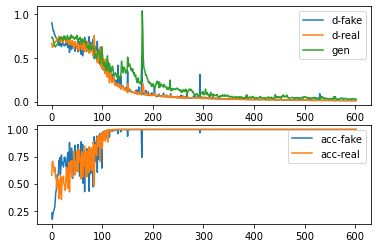

In [12]:
plt.subplot(2, 1, 1)
d_fake_hist_np = np.array(d_fake_hist)
d_real_hist_np = np.array(d_real_hist)
#print(test[0,0])
#print(test[:].shape)
plt.plot(d_fake_hist_np[:,0], label='d-fake')
plt.plot(d_real_hist_np[:,0], label='d-real')
plt.plot(g_hist, label='gen')
plt.legend()
# plot discriminator accuracy
plt.subplot(2, 1, 2)
plt.plot(d_fake_hist_np[:,1], label='acc-fake')
plt.plot(d_real_hist_np[:,1], label='acc-real')
plt.legend()
plt.show()
plt.close()